In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.linalg
import scipy.fftpack as spfft
# import scipy.ndimage as spimg
# import cvxpy as cvx

$$
(a+bi)(a-bi) = a^2 - b^2  \quad = a^2 + b^2i^2  =  (a+bi)^2 \quad \ne
\|\mathbf{x}\|_2^2 = a^2 + b^2
$$

$$
\mathbf{x} := \begin{bmatrix}a\\b\end{bmatrix}  =a + bi
$$

In [2]:
# TODO
# is direction (polsign) applied before/after superposition summation?
#    i.e. should \delta have a sign

# normalizing constant for area
#   factor before exp(): `cosfact=Gz./Gdistances`

# add original source (far away)

# check sampledichtheid

In [206]:
LAMBDA = 0.6328e-6 # wavelength in vacuum: 632.8 nm (HeNe laser)
LAMBDA = 1
DIMS = 3
PROJECTOR_DISTANCE = -4
PROJECTOR_DISTANCE = -1e3 * LAMBDA
cmap = 'rainbow'

N = 50**(DIMS-1)
N_sqrt = N if DIMS <= 2 else int(N ** (1/(DIMS-1)))
x = np.zeros(shape=(N,2)) # amplitude, phase
y = np.empty((N,2))  # amplitude, phase
z = np.empty((N,2))  # amplitude, phase

def sample_grid(N, width=1, z_offset=0, random=0):
    # spatial locations of sample points
    N_sqrt = N if DIMS <= 2 else int(N ** (1/(DIMS-1)))
    w = np.stack(np.unravel_index(np.arange(N), (N_sqrt,) * (DIMS-1)) + (np.zeros(N),), axis=1)
    # i.e. w = (range(N), range(N), (0,..)).reshape(N,3)    
    if DIMS == 3:
        # scale & center, then offset first dims
        # note that the N-th index points to the cell in the outer-most corner, at (N_sqrt-1, N_sqrt-1)
        w[:,0] = (w[:,0] / (N_sqrt-1) - 0.5) * width
        w[:,1] = (w[:,1] / (N_sqrt-1) - 0.5) * width
        if random:
            inter_width = width / N_sqrt
            w[:,:-1] += np.random.uniform(-0.5,0.5,(N,DIMS-1)) * inter_width * random
    else:
        raise NotImplementedError()

    w[:, -1] = z_offset
    return w


def to_polar(a, phi):
    return a * np.exp(phi * 1j)


def from_polar(c, distance=1):
    # polar \in C \to (amplitude, phase)
    # sum wave superposition components
    amplitude = np.abs(c)
    phase = np.angle(c)
    if np.sign(distance) == -1:
        return amplitude, -phase
    return amplitude, phase


def f(amplitude, phase, w, v, direction=1): # should direction be here?
    """
    amplitude = origin amplitude
    phase = origin phase
    
    all spatial dims (except the last) for v,w must be perpendicular to the last dim
    
    direction = -1 or +1 and must be specified manually
    """
    # single wave superposition component
    delta = scipy.linalg.norm(v - w, ord=2, axis=-1)
    assert np.all(delta > 0)

    # \hat phi = A exp(\i(omega t - xt + phi))
    next_phase = phase - direction * 2 * np.pi * delta / LAMBDA
    next_amplitude = amplitude / delta
    return to_polar(next_amplitude, next_phase)


def vec_to_im(x):
    N = np.shape(x)[0]
    d = np.sqrt(N).astype(int)
    return x.reshape((d,d))

def split_wave_vector(x):
    return vec_to_im(x[:,0]), vec_to_im(x[:,1])

def Fresnel_number(a, L):
    # a = aperture width, L = distance
    return a**2 / L / LAMBDA

def near(a, L):
    # a = aperture width, L = distance    
    # https://en.wikipedia.org/wiki/Fresnel_diffraction
    theta = a/L
    F = Fresnel_number(a, L)
    if F * theta**2 / 4 > 1:
        print('Warning, phase terms of third order and higher must be negligible')

    if 1 <= F <= 100:
        print('Warning, F is near 1, for F = %0.2f' % F)
    return F > 1

def irradiance(E):
    # Irradiance (bestralingssterkte)
    return np.abs(E * np.conjugate(E))

def normalize_amplitude(x):
    x[:, 0] *= 1/np.max(x[:, 0])

    
def plot_matrix(x, title=''):
    global cmap
    plt.figure()
    plt.imshow(x.T, cmap=cmap, vmin=0, origin='lower')
    plt.colorbar()
    plt.title(title)

def plot_slice(y, v=None):
    a = vec_to_im(y[:, 0])
    phi = vec_to_im(y[:, 1])
    plt.figure(figsize=(6,3))
    plt.subplot(121)
#     b = (a * np.sin(phi)).reshape((N_sqrt,N_sqrt))[N_sqrt//2]
#     b = np.mean((a * np.sin(phi)).reshape((N_sqrt,N_sqrt)), axis=0)
    b = np.mean(irradiance(to_polar(a, phi)).reshape((N_sqrt,N_sqrt)), axis=1)
    plt.plot(b)
    plt.title('slice 1')
    plt.subplot(122)
    b = np.mean((a * np.sin(phi)).reshape((N_sqrt,N_sqrt)), axis=0)
    plt.plot(b)
    plt.title('slice2')
    plt.tight_layout()
    if v is not None:
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        b = irradiance(to_polar(a, phi))
        plt.scatter(v[:,0], b, s=2, alpha=0.8)
        plt.subplot(122)
        plt.scatter(v[:,1], b, s=2, alpha=0.8)
        plt.tight_layout()

near False
near False


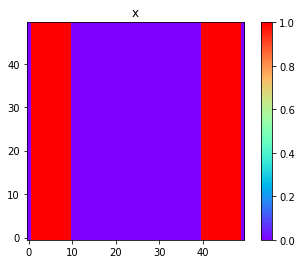

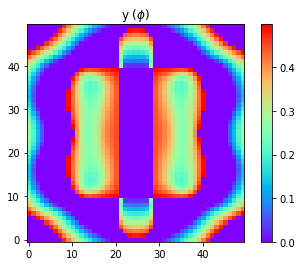

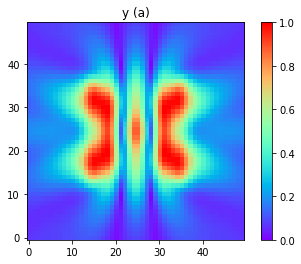

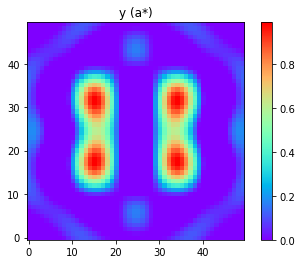

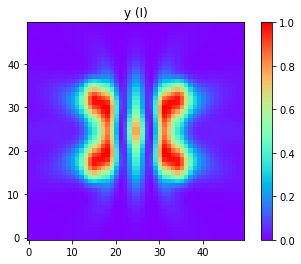

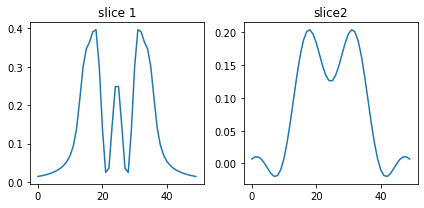

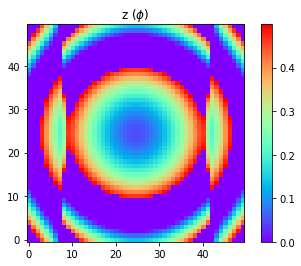

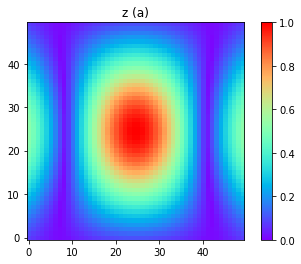

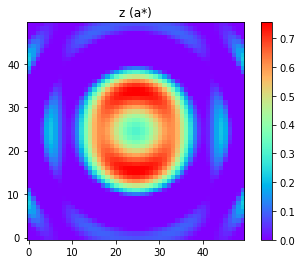

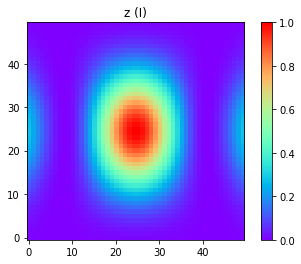

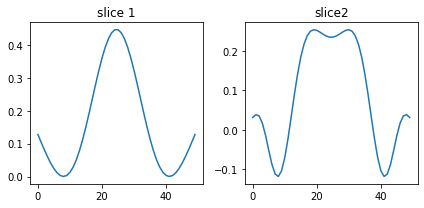

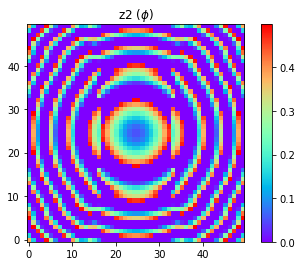

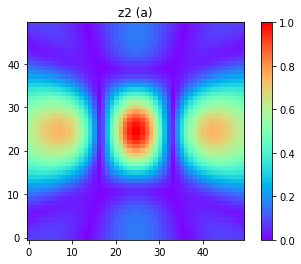

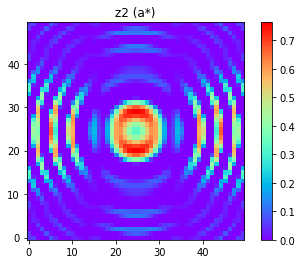

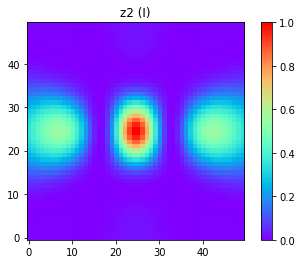

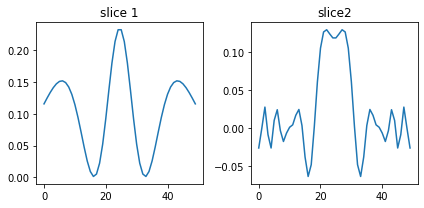

In [207]:
d1 = -1e-1 * LAMBDA
d2 = -1e1 * LAMBDA
w = sample_grid(N, 2*LAMBDA, 0)
v = sample_grid(N, 4*LAMBDA, d1)
u = sample_grid(N, 1e1*LAMBDA, d2)
print('near', near(2*LAMBDA, d1))
print('near', near(2*LAMBDA, d2))

# center pixel
# x[N//2 + N_sqrt//2, 0] = 1
x[:] = 0
a = x[:,0].reshape((N_sqrt, N_sqrt))
# a[20:30, 20:30] = 1
a[1:10] = 1
a[-10:-1,] = 1
x[:,0] = a.flatten()

for m in range(N):
    y[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, v[m])), distance=-1)
    z[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, u[m])), distance=-1)

normalize_amplitude(y)
normalize_amplitude(z)

def plot_matrix_multiple(y, prefix=''):
    a,phi = split_wave_vector(y)
    plot_matrix(vec_to_im(y[:, 1]) / np.pi / 2, r'%s ($\phi$)' % prefix)
    plot_matrix(vec_to_im(y[:, 0]), '%s (a)' % prefix)
    plot_matrix(a * np.sin(phi), '%s (a*)' % prefix)
    plot_matrix(irradiance(to_polar(a,phi)), '%s (I)' % prefix)
    plot_slice(y)
    

plot_matrix(vec_to_im(x[:, 0]), 'x')
plot_matrix_multiple(y, 'y')
plot_matrix_multiple(z, 'z')

u2 = sample_grid(N, 20 * LAMBDA, d2)

for m in range(N):
    z[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, u2[m])), distance=-1)

normalize_amplitude(z)

plot_matrix_multiple(z, 'z2')

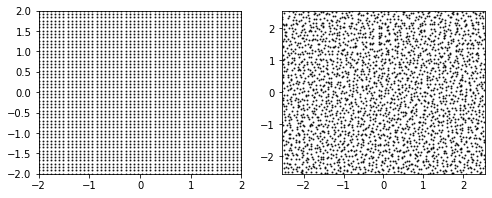

In [208]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.8, color='0')
plt.xlim(v[:,:2].min(), v[:,:2].max())
plt.ylim(v[:,:2].min(), v[:,:2].max())

N2 = 50**2
v = sample_grid(N2, 5 * LAMBDA, d1, random=1)
u = sample_grid(N2, 100 * LAMBDA, d2, random=1)

plt.subplot(122)
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.8, color='0')
plt.xlim(v[:,:2].min(), v[:,:2].max())
plt.ylim(v[:,:2].min(), v[:,:2].max());

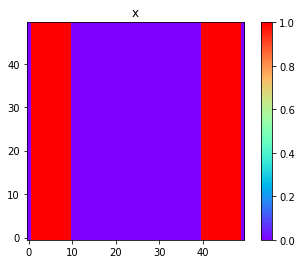

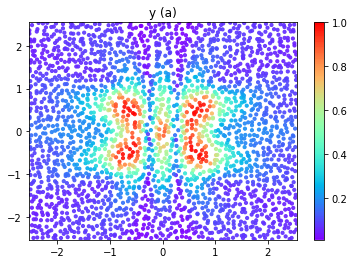

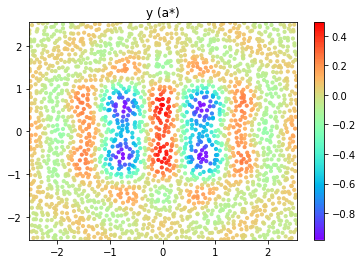

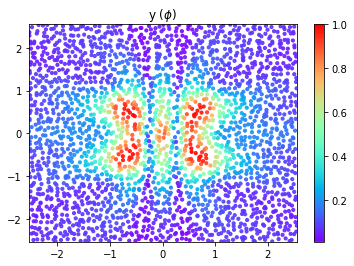

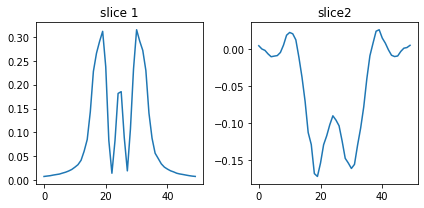

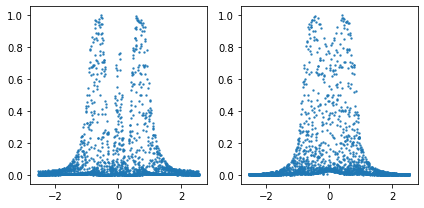

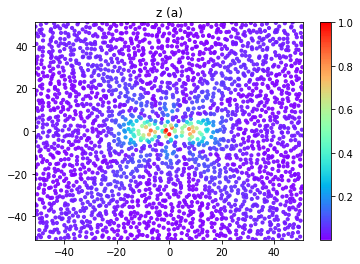

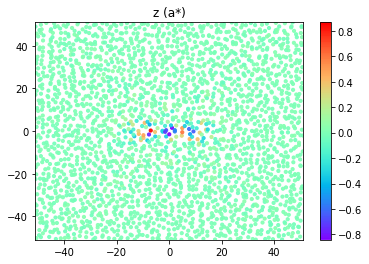

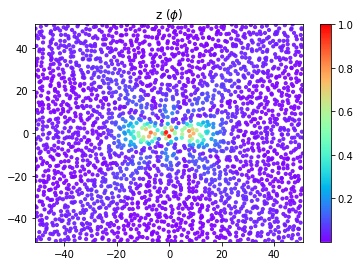

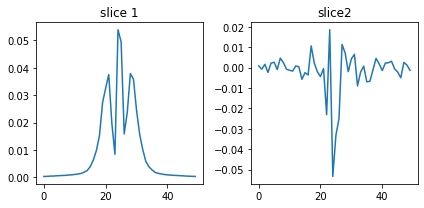

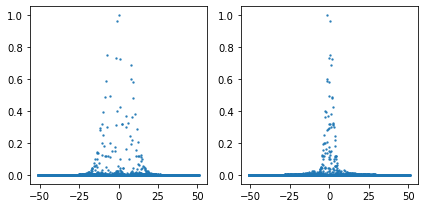

In [209]:
y = np.empty((N2,2))  # amplitude, phase
z = np.empty((N2,2))  # amplitude, phase

for m in range(v.shape[0]):
    y[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, v[m])), distance=1)
    z[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, u[m])), distance=1)
    
normalize_amplitude(y)
normalize_amplitude(z)

def plot_scatter(x,w, title='', color_func=lambda a,phi: a, s=10, alpha=0.9, **kwargs):
    global cmap
    a = x[:, 0]
    phi = x[:, 1]
    plt.figure()
    plt.scatter(w[:,0], w[:,1], c=color_func(a, phi), s=s, alpha=alpha, cmap=cmap, **kwargs)
    plt.xlim(w[:,:2].min(), w[:,:2].max())
    plt.ylim(w[:,:2].min(), w[:,:2].max())
    plt.colorbar()
    plt.title(title)
    return plt

def plot_scatter_multiple(y,v,prefix):
    plot_scatter(y, v, '%s (a)' % prefix)
    plot_scatter(y, v, '%s (a*)' % prefix, lambda a,phi: a * np.sin(phi))
    plot_scatter(y, v, r'%s ($\phi$)' % prefix)
    plot_slice(y, v)
    

plot_matrix(vec_to_im(x[:, 0]), 'x')
plot_scatter_multiple(y, v, 'y')
plot_scatter_multiple(z, u, 'z')

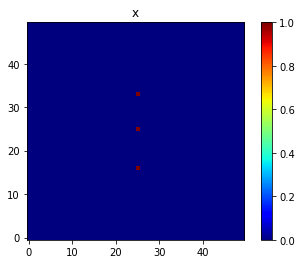

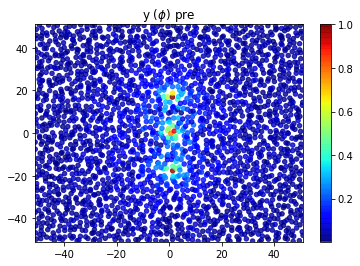

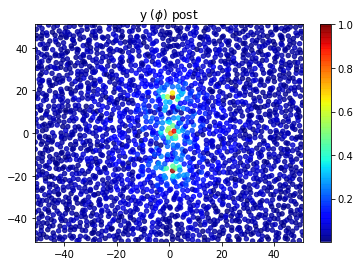

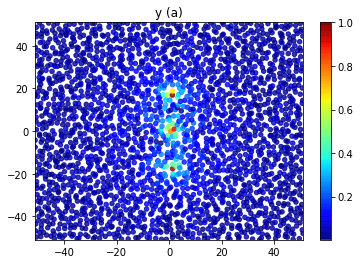

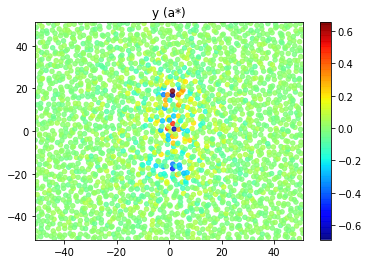

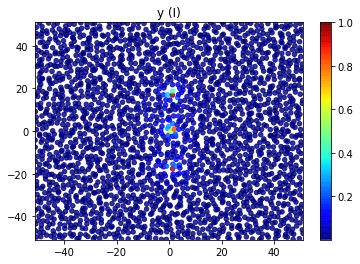

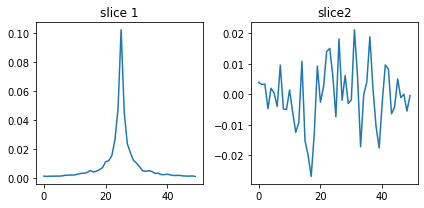

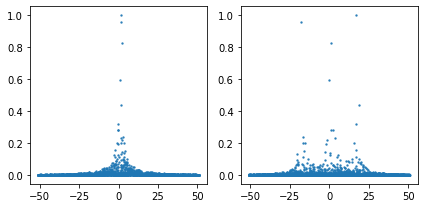

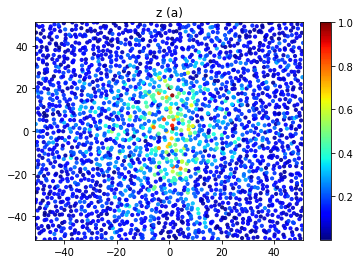

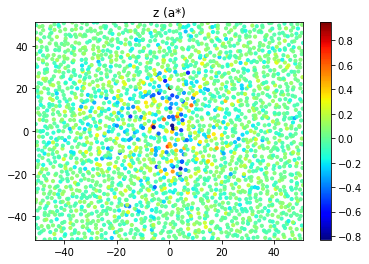

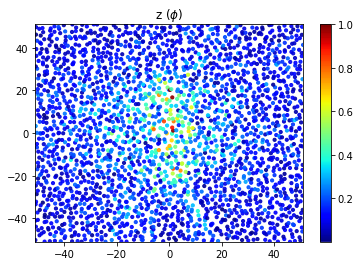

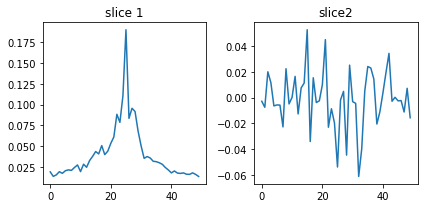

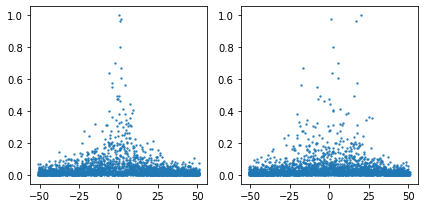

In [211]:
width = 1e2*LAMBDA
# w = sample_grid(N, 1e2 * width, 0)
# v = sample_grid(N, width, -1e3 * LAMBDA)
# u = sample_grid(N, e2 * width, 1 * LAMBDA)
w = sample_grid(N, width, 0)
v = sample_grid(N, width, -1e-2 * width, random=1)
u = sample_grid(N, width, 0* width, random=1)

x = np.zeros((N,2))  # amplitude, phase
y = np.empty((N,2))  # amplitude, phase
z = np.empty((N,2))  # amplitude, phase

# center pixel
x[N//2 + N_sqrt//2, 0] = 1
x[N//2 + N_sqrt//3, 0] = 1
x[N//2 + 2*N_sqrt//3, 0] = 1
# a = x[:,0].reshape((N_sqrt, N_sqrt))
# a[20:30, 20:30] = 1
# a[21:29, 21:29] = 0
# x[:,0] = a.flatten()

for m in range(y.shape[0]):
#     y[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, v[m])), distance=-1)
    y[m, :] = from_polar(np.sum(f(x[:,0], x[:,1], w, v[m], direction=1)), distance=-1)

normalize_amplitude(y)

cmap = 'jet'
plot_matrix(vec_to_im(x[:, 0]), 'x')
plot_scatter(y, v, r'y ($\phi$) pre', s=20, alpha=0.8)

# add far away light source
mean = np.mean(y[:, 0])
for m in range(y.shape[0]):
    source = np.array((0,) * (DIMS-1) + (-1e5 * width,))
    sum_ = to_polar(*y[m]) + f(mean, 0, source, v[m])
    y[m, :] = from_polar(sum_, distance=np.sqrt(2) * PROJECTOR_DISTANCE)

normalize_amplitude(y)

    
for ell in range(z.shape[0]):
    z[ell, :] = from_polar(np.sum(f(y[:,0], y[:,1], v, u[ell])))

normalize_amplitude(z)


plot_scatter(y, v, r'y ($\phi$) post', s=20, alpha=0.8)
plot_scatter(y, v, 'y (a)', s=20, alpha=0.8)
plot_scatter(y, v, 'y (a*)', lambda a,phi: a * np.sin(phi), s=20, alpha=0.8)
plot_scatter(y, v, 'y (I)', lambda a,phi: irradiance(to_polar(a,phi)), s=20, alpha=0.8)
plot_slice(y, v)

plot_scatter_multiple(z, u, 'z')

In [ ]:
# plt.figure()
# plt.imshow(vec_to_im(y[:, 1]) / np.pi / 2, cmap=cmap)
# plt.colorbar()
# plt.title(r'y ($\phi$) post')


# plt.figure()
# plt.imshow(vec_to_im(y[:, 0]), cmap=cmap, vmin=0)
# plt.colorbar()
# plt.title('y (a)')


# plt.figure()
# a = vec_to_im(y[:, 0])
# phi = vec_to_im(y[:, 1])
# plt.imshow(a * np.sin(phi), cmap=cmap, vmin=0)
# # plt.imshow(vec_to_im(y[:, 0]), cmap='jet', vmin=0)
# plt.colorbar()
# plt.title('y* (a)')

# plt.figure()
# # plt.imshow(np.log(1+10e4*vec_to_im(z[:, 0])), cmap=cmap, vmin=0)
# plt.imshow(vec_to_im(z[:, 0]), cmap=cmap, vmin=0)
# plt.colorbar()
# plt.title('z (a)')

# plt.figure()
# a = vec_to_im(z[:, 0])
# phi = vec_to_im(z[:, 1])
# plt.imshow(a * np.sin(phi), cmap=cmap, vmin=0)
# plt.colorbar()
# plt.title('z (a*)')

# plt.figure()
# plt.imshow(vec_to_im(z[:, 1]) / np.pi / 2, cmap=cmap)
# plt.colorbar()
# plt.title(r'z ($\phi$)');

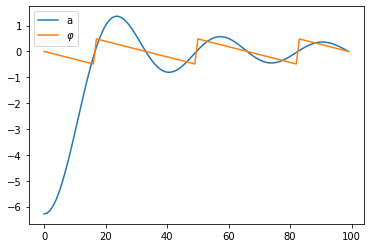

In [202]:
# a line of measurement points
N = 100
v = np.zeros((N,2))
v[:,0] = np.linspace(0, 3*LAMBDA, N)
x = from_polar(f(1, 0, 0.001 * LAMBDA, v))
plt.plot(x[0] * np.sin(x[1]), label='a')
plt.plot(x[1] / 2 / np.pi, label=r'$\varphi$')
plt.legend()

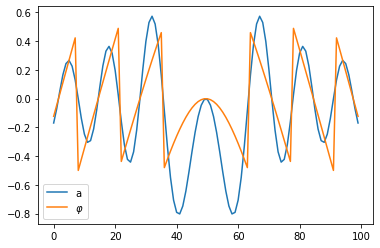

In [10]:
# a plane of measurement points, perpendicular
N = 100
half_size = 4*LAMBDA
v = np.zeros((N,3))
v[:,1] = 1
v[:,0] = np.linspace(-half_size, half_size, N)
x = from_polar(f(1, 0, 0, v))
plt.plot(x[0] * np.sin(x[1]), label='a')
plt.plot(x[1] / 2 / np.pi, label=r'$\varphi$')
plt.legend()